In [1]:
import pandas as pd
import numpy as np

In [2]:
pdf = pd.read_csv('../Data/PD.csv')

In [3]:
# Remove these rows because this is the only account with Open Amount as 0
pdf = pdf[pdf.AcctID != '30705504-000']

In [4]:
pdf['EOMDate'] = pd.to_datetime(pdf['YrMoDt'])
pdf['EOMOpenDt_YrMo'] = pd.to_datetime(pdf['EOMOpenDt_YrMo'])
pdf['EOMMaturityDt_YrMo'] = pd.to_datetime(pdf['EOMMaturityDt_YrMo'])
pdf['EOMCloseDt_YrMo'] = pd.to_datetime(np.where(
                                                np.logical_and(pdf.EOMCloseDt_YrMo.isnull(), (pdf.Closed_Flag == 1)), 
                                        pdf.YrMoDt, pdf.EOMCloseDt_YrMo))
pdf['EOMDefaultDt_YrMO'] = pd.to_datetime(np.where(pdf.Default_Flag == 1, pdf.EOMDate, None))
pdf = pdf.drop(columns = ['YrMoDt'])

In [5]:
cols = ['OpenAmt_YrMo', 'Unpaid_Balance_Amt', 'Off_Balance_Amt']
pdf[cols] = pdf[cols].apply(lambda x: x.str.replace('[^0-9.]*', '', regex = True).astype(float))

cols = ['Term_YrMo', 'MOB', 'RevolveIn', 'FixedRtIn', 'Default_Flag', 'Closed_Flag', 'Prepay_Flag']
pdf[cols] = pdf[cols].astype(float)

In [6]:
pdf = pdf[pdf['SECSegmentDe_YrMo'] == "Commercial and Industrial"]
# Remove the below columns. They are single values (No Variance)
pdf = pdf.drop(columns = ["SECSubSegmentDe_YrMo"])

In [7]:
# Remove rows that are showing data for 
pdf = pdf[pdf.EOMMaturityDt_YrMo >= pdf.EOMDate]

In [8]:
# For some rows we have Closed date but the closed flag is not null. Fix this
pdf['Closed_Flag'] = pd.Series(np.logical_or(pdf.Closed_Flag, pdf.EOMCloseDt_YrMo.notnull())).astype(float)

In [9]:
print("Total Unpaid Balance for account rows later than Closed Date", 
      pdf[pdf.EOMDate > pdf.EOMCloseDt_YrMo]['Unpaid_Balance_Amt'].sum())
# Remove all loans that are closed and have no remaining unpaid balance amount
pdf = pdf[~(pdf.EOMDate > pdf.EOMCloseDt_YrMo)]

Total Unpaid Balance for account rows later than Closed Date 0.0


In [10]:
pdf = pdf.dropna(subset = ['From_RiskCd', 'To_RiskCd'])

In [11]:
# Checking the values of risk group, about 90% of the data is RiskCd 7. 
# And 92% of the data falls in Group A. We impute 7 which falls into group D
pdf['From_Risk_Group'] = pd.cut(pdf['From_RiskCd'], bins=  [0, 8, 9, 11, 14], include_lowest = True, 
                                                labels = ['A', 'B', 'C', 'D'])

In [12]:
# To Risk is imputed with the value in From Risk
pdf['To_Risk_Group'] = np.where((pdf['Closed_Flag'] + pdf['Prepay_Flag']) == 1, "E",
                                        pd.cut(pdf['To_RiskCd'], bins=  [0, 8, 9, 11, 14], include_lowest = True, 
                                                labels = ['A', 'B', 'C', 'D']
                                              ),
                        )

# ECON DATA PREP

In [13]:
econ = pd.read_csv('../Data/ECON.csv')

In [14]:
econ['DATE'] = pd.to_datetime(econ['DATE'])
econ = econ[econ.DATE.between("2008-12-31", "2016-12-31")]
econ = econ.apply(lambda x: x.str.replace('[^0-9.]*', '', regex = True).astype(float) if x.dtype == 'object' else x)
cols = econ.columns.sort_values().tolist()

In [15]:
bbb_rate_cols = cols[:10]
bbb_10yr_spread_cols = cols[10:20]

cre_index_cols = cols[20:36]

djia_cols = cols[38:53]

gdp_nominal_cols = cols[54:69]
gdp_real_cols = cols[69:80] + cols[96:101]
gdp_tx_cols = cols[80:96]

hpi_fhfa_cols = cols[101:112] + cols[128:133]
hpi_fhfa_tx_cols = cols[112:128]

ir_10yr_cols = cols[133:143]
ir_5yr_cols = cols[143:153]

mort_rate_cols = cols[153:163]
mort_10yr_spread_cols = cols[163:173]

prime_rate_cols = cols[173:183]

tr_3mo_cols = cols[183:193]
tr_10yr_3mo_spread_cols = cols[193:203]

unemp_claims_cols = cols[203:219]
unemp_rate_cols = cols[219:229]
unemp_rate_tx_cols = cols[229:239]

wti_oil_cols = cols[239:]

In [16]:
col_order = bbb_rate_cols + bbb_10yr_spread_cols + \
                cre_index_cols + \
                djia_cols + \
                gdp_nominal_cols + gdp_real_cols + gdp_tx_cols + \
                hpi_fhfa_cols + hpi_fhfa_tx_cols + \
                ir_10yr_cols + ir_5yr_cols + \
                mort_rate_cols + mort_10yr_spread_cols + \
                prime_rate_cols + \
                tr_3mo_cols + tr_10yr_3mo_spread_cols + \
                unemp_claims_cols + unemp_rate_cols + unemp_rate_tx_cols + \
                wti_oil_cols

In [17]:
# Take BBB Rate and analyse the features

<Axes: xlabel='DATE'>

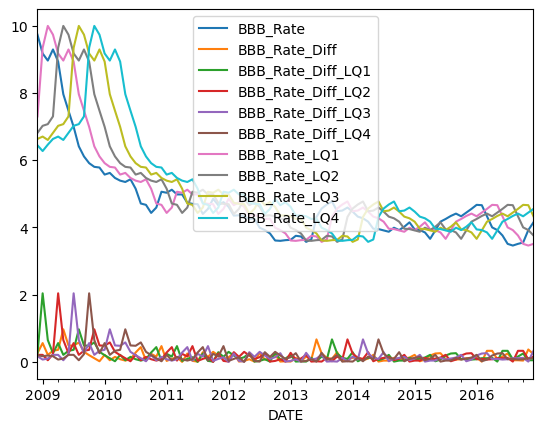

In [18]:
econ[bbb_rate_cols + ['DATE']].plot.line(x = 'DATE')

In [19]:
# The line plt shows there's a 100% correlation between LQ1, LQ2, LQ3, LQ4

<Axes: xlabel='DATE'>

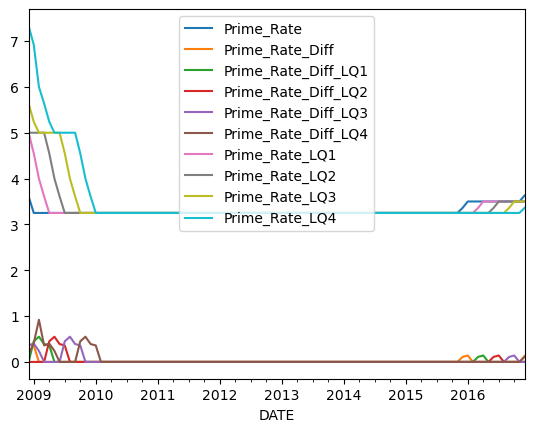

In [20]:
econ[prime_rate_cols + ['DATE']].plot.line(x = 'DATE')

In [21]:
# The prime rate seems to remain constant for most of the years having low variance
# We will remove the columns with low variance

In [22]:
econ_desc = econ.apply(lambda x: x if x.name == "DATE" else (x - x.min()) / (x.max() - x.min())).describe()

In [23]:
expected_feature_variance = (econ_desc.loc['std', :] / econ_desc.loc['75%', :]).astype(float).replace(np.inf, np.NaN).dropna()

In [24]:
expected_feature_variance.describe()
# Let's chose median and drop columns with variances less than the median (.558 - (error = .05))

count    244.000000
mean       0.679800
std        0.482064
min        0.253360
25%        0.451658
50%        0.558400
75%        0.750662
max        4.118314
dtype: float64

In [25]:
non_low_variance_cols = expected_feature_variance[expected_feature_variance >= (expected_feature_variance.describe().quantile(.5) - .05)].index.tolist()

In [26]:
corr_df = econ[non_low_variance_cols].corr()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
drop_corr_cols = [column for column in corr_df.columns if any(corr_df[column].abs() > 0.7)]

In [27]:
corr_df = corr_df.drop(columns = drop_corr_cols, index = drop_corr_cols)

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [29]:
selected_cols = corr_df.columns.tolist()

vif = pd.DataFrame([[variance_inflation_factor(econ.assign(constant=1)[selected_cols + ['constant']].values, i) 
                             for i in range(len(selected_cols) + 1)]], 
            columns = selected_cols + ['constant']).T

In [30]:
econ_final_cols = vif[vif[0] <= 10].index.tolist()

In [31]:
econ = econ[econ_final_cols + ['DATE']]

In [32]:
pdf = pdf.merge(econ, left_on = 'EOMDate', right_on = 'DATE', how = 'left').drop(columns = ['DATE'])

econ_interpolated = pdf.drop_duplicates(subset = econ_final_cols + ["EOMDate"]).set_index("EOMDate").\
                            sort_index()[econ_final_cols].interpolate(limit_direction = "both", method = 'time')

pdf = pdf.merge(econ_interpolated.reset_index(), on = "EOMDate", suffixes = ['_NA', ''], how = 'left')

pdf = pdf.drop(columns = [i + "_NA" for i in econ_final_cols])

In [33]:
snapshot_min_year = "2008-12-31"
snapshot_max_year = "2016-12-31"

In [34]:
closed_defaulted_acc = pdf.loc[(pdf.EOMCloseDt_YrMo < snapshot_min_year) | (pdf.EOMDefaultDt_YrMO < snapshot_min_year), 'AcctID'].unique().tolist()

snapshot_data = pdf[(pdf.EOMMaturityDt_YrMo >= snapshot_min_year) & 
           (pdf.EOMOpenDt_YrMo <= snapshot_min_year) & 
           ~(pdf.AcctID.isin(closed_defaulted_acc))]

In [35]:
snapshot_data.shape

(45802, 81)

In [36]:
pdf.to_csv('../Data/cleaned_data.csv', index = False)
snapshot_data.to_csv('../Data/snapshot_data.csv', index = False)